## <font color="#0000E0"> X522 Machine Learning For Business Applications </font>
### <font color="#0000E0"> Professor Owen Wu </font>
### <font color="#0000E0"> Timothy Tan </font>
### <font color="#0000E0"> Subject:  Using machine learning to predict the next day's closing stock of the SPY ETF in relationship to the previous days data. </font>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [38]:
#d.options.display.max_rows=5
df0 = pd.read_csv("spy.csv")
df = df0.copy()
os.getcwd()

'C:\\Users\\tim\\Code\\x522'

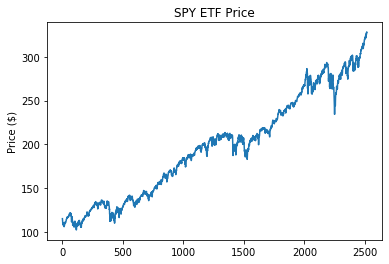

In [39]:
plt.plot(df.index, df['close'])
plt.title("SPY ETF Price")
plt.ylabel('Price ($)')
plt.figure(1,figsize=(8,4))
plt.show()

### Converting date into an index.

In [40]:
df['date'] = pd.to_datetime(df.date)
df['date'] = df['date'].astype(str)

In [41]:
print(df.dtypes, "\n")
print(df.describe())

date                      object
open                     float64
high                     float64
low                      float64
close                    float64
volume                     int64
7sma                     float64
14sma                    float64
previous_close           float64
next_day_higher_close     object
dtype: object 

              open         high          low        close        volume  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean    197.065791   197.972190   196.060680   197.097468  1.265564e+08   
std      59.039598    59.176438    58.872503    59.035926  7.504939e+07   
min     103.110000   103.420000   101.130000   102.200000  0.000000e+00   
25%     139.112500   139.832500   138.545000   139.325000  7.496575e+07   
50%     198.995000   200.005000   198.250000   199.285000  1.068580e+08   
75%     243.972500   244.817500   243.200000   244.037500  1.568897e+08   
max     327.470000   329.020000   327.260000   328.190

### Converting fields with zero values to null values, then remove any row with missing values.

In [42]:
df = df.replace( { '7sma': 0, '14sma': 0, 'previous_close': 0}, np.nan)
df = df.dropna(how='any')
#df.isnull()
#df.isnull().sum()

In [43]:
df = df.set_index(df['date'])
df

date    open    high     low   close     volume    7sma  \
date                                                                        
2010-02-05  2010-02-05  106.56  106.88  104.58  106.66  493585800  108.33   
2010-02-08  2010-02-08  106.74  107.33  105.81  105.89  224166900  107.95   
2010-02-09  2010-02-09  107.13  108.15  106.27  107.22  337820500  107.93   
2010-02-10  2010-02-10  107.05  107.60  106.11  107.01  240511500  107.63   
2010-02-11  2010-02-11  106.87  108.25  106.25  108.13  223591600  107.31   
...                ...     ...     ...     ...     ...        ...     ...   
2020-01-09  2020-01-09  326.16  326.73  325.52  326.65   48473300  323.80   
2020-01-10  2020-01-10  327.29  327.46  325.20  325.71   53029300  324.35   
2020-01-13  2020-01-13  326.39  327.96  325.92  327.95   47086800  324.79   
2020-01-14  2020-01-14  327.47  328.62  326.84  327.45   62832800  325.51   
2020-01-15  2020-01-15  327.35  329.02  327.26  328.19   71911200  326.16   

             14sma  previous_close next_day_higher_close  
date                                                      
2010-02-05  109.79          106.44                 lower  
2010-02-08  109.14          106.66                higher  
2010-02-09  108.66          105.89                 lower  
2010-02-10  108.33          107.22                higher  
2010-02-11  108.25          107.01                 lower  
...            ...             ...                   ...  
2020-01-09  322.68          324.45                 lower  
2020-01-10  323.03          326.65                higher  
2020-01-13  323.54          325.71                 lower  
2020-01-14  323.99          327.95                higher  
2020-01-15  324.49          327.45                higher  

[2503 rows x 10 columns]

## <font color="#0000E0"> Selecting the features to use

In [44]:
X = df.loc[:, ['open', 'high', 'low', 'close', 'volume', '7sma', '14sma','previous_close']].to_numpy()
y = df.loc[:, 'next_day_higher_close'].to_numpy()

print("Data type of predictors X: ", X.dtype, X.shape)
print("Data type of target variable y: ", y.dtype, y.shape)
print(np.unique(y))

Data type of predictors X:  float64 (2503, 8)
Data type of target variable y:  object (2503,)
['higher' 'lower']


## <font color="#0000E0"> Labeling the data

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()  # create an encoder

le.fit(y)  # Fitting step
print(le.classes_)

y = le.transform(y)  # Transforming step
print(y)

['higher' 'lower']
[1 0 1 ... 1 0 0]


## <font color="#0000E0"> Splitting the data

In [46]:
from sklearn.model_selection import train_test_split

testsize = 0.2

# Remove stratify and random state due to time sensitive nature of securities
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testsize) # stratify=y, random_state=0

In [47]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [1376 1127]
Labels counts in y_train: [1119  883]
Labels counts in y_test: [257 244]


## <font color="#0000E0"> Fitting the data

In [48]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## <font color="#0000E0"> First Logistic run

Test set: 
 [[225.62 226.75 225.61 ... 225.15 225.49 225.24]
 [132.4  133.62 132.39 ... 131.86 132.65 131.21]
 [266.89 268.02 266.11 ... 264.97 265.73 266.02]
 ...
 [283.22 283.8  279.18 ... 281.82 279.84 284.73]
 [119.54 120.18 118.82 ... 119.36 122.37 116.34]
 [209.72 211.05 209.65 ... 207.44 207.74 209.77]]
Probabilistic prediction: 
 [[0.53203927 0.46796073]
 [0.51987161 0.48012839]
 [0.53144861 0.46855139]
 ...
 [0.62446448 0.37553552]
 [0.50977    0.49023   ]
 [0.53662551 0.46337449]]

Predicted class:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

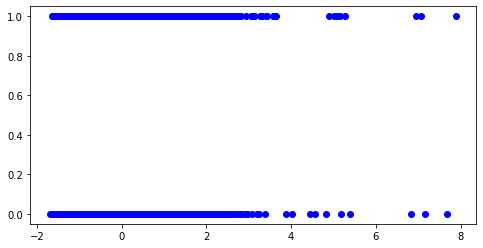

In [49]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)

print('Test set: \n', X_test)
print("Probabilistic prediction: \n", lr.predict_proba(X_test_std))
print("\nPredicted class: ", lr.predict(X_test_std))
print("Actual class:    ", y_test)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
plt.figure(1,figsize=(8, 4))
plt.plot(X_train_std, y_train, 'bo')
plt.plot(X_test_std, y_test, 'bo')

### Scatter Plot

mean = [-0.  0.  0.  0. -0.  0.  0.  0.]
stdev= [1. 1. 1. 1. 1. 1. 1. 1.]


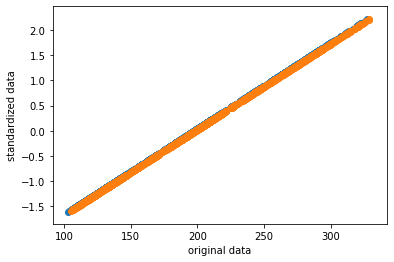

In [50]:
np.set_printoptions(suppress=True)
print("mean =", X_train_std.mean(axis=0))
print("stdev=", X_train_std.std(axis=0))

plt.scatter(X_train[:,0], X_train_std[:,0])
plt.scatter(X_train[:,1], X_train_std[:,1])
plt.xlabel('original data')
plt.ylabel('standardized data')
plt.show()

## <font color="#0000E0"> Increase regularization strength.
Does nothing for the accuracy.

In [51]:
lr = LogisticRegression(C=100, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.5604395604395604
Test accuracy: 0.5089820359281437


## Creating the ensemble

In [52]:
#------------------------------------------------------------------------------------------------------------
# Define three classification models and an ensemble of these three models
clf1 = DecisionTreeClassifier(max_depth=4, random_state=0)
clf2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=7))
clf3 = make_pipeline(StandardScaler(), SVC( C=1, gamma=0.01, kernel='rbf', probability=True, random_state=0))

from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('dt', clf1), ('pipe1', clf2), ('pipe2', clf3)], voting='soft')

## <font color="#0000E0"> Recursive Feature Elimination (RFE) </font>
### Select the top features for the n number of paramters

In [ ]:
lr = LogisticRegression(C=1000, solver='liblinear', multi_class='ovr')

# Construct the feature selector
from sklearn.feature_selection import RFE
rfe = RFE(estimator=lr, n_features_to_select=5)

# Select features
rfe.fit(X_train_std, y_train)
print('Feature ranking: Selected features are ranked 1: ', rfe.ranking_)
print(np.vstack((rfe.ranking_, df.columns[1:-1])).T)
X_train_rd = rfe.transform(X_train_std)
X_test_rd =  rfe.transform(X_test_std)

# Verify the selected features are indeed from desired columns
#dif = X_train_rd - X_train_std[:,[6,9]]
#print(np.mean(dif), np.std(dif))

# Train the model using only the selected features
lr.fit(X_train_rd, y_train)
print("Training accuracy: ", lr.score(X_train_rd, y_train))
print("Test accuracy: ", lr.score(X_test_rd, y_test))

## <font color="#0000E0"> Recursive Feature Elimination with Cross Validation (RFECV) </font>
### Select optimal number of features to use
For some odd reason, the number of features to select flips between 1 and 6, depending on C.

In [ ]:
lr = LogisticRegression(C=100, solver='liblinear', multi_class='ovr')

# Construct the feature selector
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=lr, cv=10)

# Select features
rfecv.fit(X_train_std, y_train)
print('Best number of features to select:', rfecv.n_features_,
      '\nFeature ranking: Selected features are ranked 1:\n',
      np.vstack((rfecv.ranking_, df.columns[1:-1])).T)
X_train_rd = rfecv.transform(X_train_std)
X_test_rd =  rfecv.transform(X_test_std)

# Train the model using only the selected features
lr.fit(X_train_rd, y_train)
print("Training accuracy: ", lr.score(X_train_rd, y_train))
print("Test accuracy: ", lr.score(X_test_rd, y_test))

### Get average and stdev of validation accuracy

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10, gamma=1)
svm
svm.get_params()

scores = cross_val_score(estimator=svm, X=X_train_std, y=y_train, cv=10)

print('10-fold cross validation accuracy:', scores)
print('\nAverage and stdev of validation accuracy: ',  np.mean(scores), np.std(scores))

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
#param_range = np.logspace(-5, 1, 25)
#print(param_range)

train_scores, val_scores = validation_curve(estimator=svm, X=X_train_std, y=y_train, cv=10,
                                            param_name='gamma', 
                                            param_range=param_range)

print('For gamma = 1, validation accuracy is:', val_scores[5], '\nAverage validation accuracy: ', np.mean(val_scores[5]))

In [ ]:
print('val_scores table has %d rows and %d columns:\n' % val_scores.shape)
with np.printoptions(precision=4): 
    print(val_scores)
print('\nRow averages =', np.mean(val_scores, axis=1))

In [ ]:
trn_mean = np.mean(train_scores, axis=1)
trn_std  = np.std (train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std  = np.std (val_scores, axis=1)

plt.figure(figsize=(12,6))
plt.plot(param_range, trn_mean, 'bo-',  markersize=5, label='training accuracy')
plt.fill_between(param_range, trn_mean+trn_std, trn_mean-trn_std, alpha=0.25, color='blue')

plt.plot(param_range, val_mean, 'gs--', markersize=5, label='validation accuracy')
plt.fill_between(param_range, val_mean+val_std, val_mean-val_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower center')
plt.xlabel('Hyperparameter gamma')
plt.ylabel('Accuracy')
plt.savefig('val_curve_wine')
plt.show()